In [460]:
import numpy as np  
import matplotlib.pyplot as plt
from lambeq.backend.quantum import Ry, Diagram, Bra, Rx, Rz
from util import data_loader, gen_bloch_states, get_observable, plot_scatter, plot_dist, plot_heatmap, gen_states
from contextuality.model import chsh_scenario, Model
import seaborn as sns
from funcs import calc_eoe, calc_neg, state2dense, gen_basis, calc_violation, normalise, log_neg, get_table
import pandas as pd
from tqdm import tqdm
import random

In [17]:
CF_bound = 2**0.5 - 1
bell_state = np.array([1,0,0,1], dtype=np.complex128) * 1/(2**0.5)

x_basis = gen_basis(np.pi/2, 0)
y_basis = gen_basis(np.pi/2, np.pi/2)
z_basis = gen_basis()

onb1 = gen_basis(np.pi/2, np.pi/8)[0]
onb2 = gen_basis(np.pi/2, 5*np.pi/8)[0]

contexts_cc = {'ab': np.kron(onb1, onb1), 
               'aB': np.kron(onb1, onb2),  
               'Ab': np.kron(onb2, onb1),  
               'AB': np.kron(onb2, onb2)}
_observables = {'A': (get_observable('ONB1', np.pi/2, np.pi/8), get_observable('ONB2', np.pi/2, 5*np.pi/8)), 'B': (get_observable('ONB1', np.pi/2, np.pi/8), get_observable('ONB2', np.pi/2, 5*np.pi/8))}
observables = {'A': (get_observable('a1', 0, 0), get_observable('a2', np.pi/4, 0)), 'B': (get_observable('b1', np.pi/8, 0), get_observable('b2', 5*np.pi/8, 0))}
contexts_max = {'ab': np.kron(observables['A'][0].array, observables['B'][0].array),
                'aB': np.kron(observables['A'][0].array, observables['B'][1].array), 
                'Ab': np.kron(observables['A'][1].array, observables['B'][0].array), 
                'AB': np.kron(observables['A'][1].array, observables['B'][1].array)}

# bell_state = np.array([1,0,0,1]) * 1/(2**0.5)
# prs1 = abs(contexts_cc['ab'] @ bell_state)**2
# prs2 = abs(contexts_cc['aB'] @ bell_state)**2
# prs3 = abs(contexts_cc['Ab'] @ bell_state)**2
# prs4 = abs(contexts_cc['AB'] @ bell_state)**2
# Model(chsh_scenario(), convert_dist([prs1, prs2, prs3, prs4])).contextual_fraction()
subj_obj_pairs = [('heart', 'blood'), ('sailors', 'boats'), ('students', 'books'), ('knife', 'fence'),
                  ('storm', 'flight'), ('bee', 'flower'), ('birds', 'seeds'), ('police', 'criminals'), 
                  ('people', 'government'), ('sniper', 'terrorist')]
conv_arr = lambda arr: abs(np.array([ele for ele in arr]))

In [3]:
model_path = {'d_ref': 'runs/disjoint_ref_130E/best_model.lt', 
              'd_nref': 'runs/disjoint_noref_140E/best_model.lt',
              's_ref': 'runs/spider_ref_200E/best_model.lt', 
              's_nref': 'runs/spider_noref_50E/best_model.lt'}

diagram_path = {'rref': 'dataset/diagrams/diags_right_ref.pkl',
                'wref': 'dataset/diagrams/diags_wrong_ref.pkl',
                'nref': 'dataset/diagrams/diags_no_ref.pkl'}

data_path = {'d_rref': 'dataset/new_data_pkl/open-wire_right_ref.pkl',
             'd_wref': 'dataset/new_data_pkl/open-wire_wrong_ref.pkl',
             'd_nref': 'dataset/new_data_pkl/open-write_no_ref.pkl',
             's_rref': 'dataset/new_data_pkl/spider_right_ref.pkl',
             's_wref': 'dataset/new_data_pkl/spider_wrong_ref.pkl',
             's_nref': 'dataset/new_data_pkl/spider_no_ref.pkl',}

In [183]:
ow_rref = data_loader(chsh_scenario())
ow_rref.load_data(data_path['d_rref'])
ow_wref = data_loader(chsh_scenario())
ow_wref.load_data(data_path['d_wref'])
ow_nref = data_loader(chsh_scenario())
ow_nref.load_data(data_path['d_nref'])

s_rref = data_loader(chsh_scenario())
s_rref.load_data(data_path['s_rref'])
s_wref = data_loader(chsh_scenario())
s_wref.load_data(data_path['s_wref'])
s_nref = data_loader(chsh_scenario())
s_nref.load_data(data_path['s_nref'])

In [5]:
from sklearn.decomposition import PCA

In [6]:
pca = PCA(n_components=1)

<Axes: >

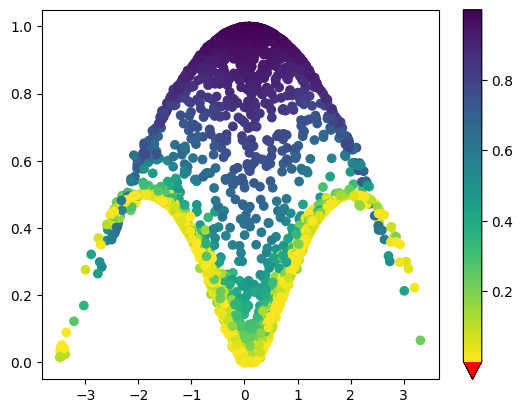

In [645]:
plot_scatter(plt.axes(), pca.fit_transform(conv_arr(s_rref.data['State'])), s_rref.data['Entropy'], s_rref.data['LogNeg'])

In [43]:
_, _, states = gen_bloch_states(10000)

In [44]:
eoe = []
logneg = []
cf = []
cbd = []
vio = []
for state in tqdm(states):
    dense_mat = state2dense(state)
    eoe.append(calc_eoe(dense_mat))
    logneg.append(log_neg(dense_mat))
    vio.append(calc_violation(state, contexts_cc))
    emp_model = Model(chsh_scenario(), get_table(state, contexts_cc))
    cf.append(emp_model.contextual_fraction())
    cbd.append(emp_model.CbD_measure())

100%|██████████| 10000/10000 [00:26<00:00, 383.77it/s]


In [53]:
pca_states = pca.fit_transform(conv_arr(states))

In [55]:
normed_pca = normalise([ele[0] for ele in pca_states])

In [81]:
normed_cbd = np.array(cbd)
normed_cbd[normed_cbd < 0] = 0

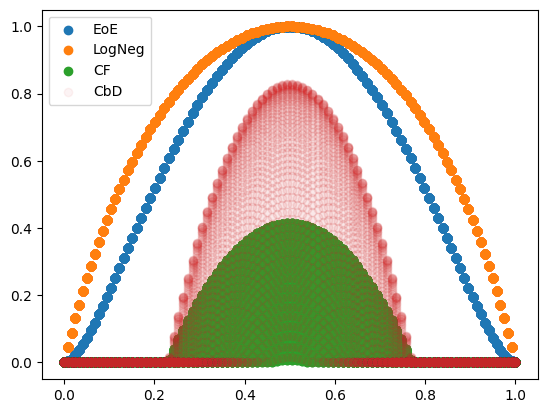

In [85]:
plt.scatter(x=normed_pca, y=eoe, label='EoE')
plt.scatter(x=normed_pca, y=logneg, label='LogNeg')
plt.scatter(x=normed_pca, y=cf, label='CF')
plt.scatter(x=normed_pca, y=normed_cbd, label='CbD', alpha=0.05)
plt.legend(loc='upper left')
plt.savefig('figures/idklol')

In [238]:
rref_states = pca.fit_transform(conv_arr(s_rref.data['State']))
wref_states = pca.fit_transform(conv_arr(s_wref.data['State']))
nref_states = pca.fit_transform(conv_arr(s_nref.data['State']))
rref_states = normalise([ele[0] for ele in rref_states])
wref_states = normalise([ele[0] for ele in wref_states])
nref_states = normalise([ele[0] for ele in nref_states])

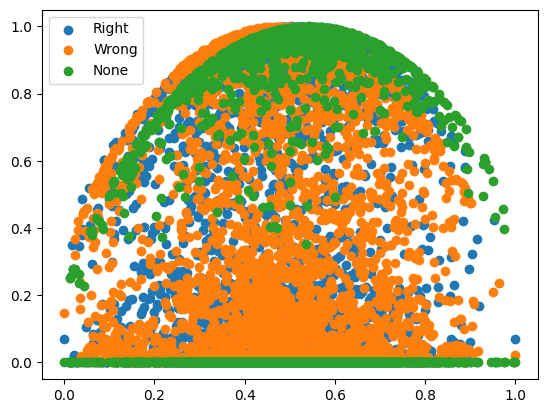

In [240]:
plt.scatter(x=rref_states, y=s_rref.data['LogNeg'], label='Right')
plt.scatter(x=wref_states, y=s_wref.data['LogNeg'], label='Wrong')
plt.scatter(x=nref_states, y=s_nref.data['LogNeg'], label='None')
plt.legend(loc='upper left')
#plt.savefig('figures/idklol')

In [512]:
from sklearn import svm
data_r, data_w = get_sim([s_rref.data.sample(frac=1), s_wref.data.sample(frac=1)])
total = len(data_r)
data_1 = data_r[:round(total*0.8)]
data_2 = data_w[:round(total*0.8)]
data = np.concatenate([list(zip(data_1['LogNeg'].to_numpy(), data_1['Entropy'].to_numpy())), 
                       list(zip(data_2['LogNeg'].to_numpy(), data_2['Entropy'].to_numpy()))])
pca = PCA(n_components=1)
data = pca.fit_transform(conv_arr(data))
# data = [[ele] for ele in data]
data = list(zip(data, [1]*round(total*0.8) + [0]*round(total*0.8)))
random.shuffle(data)
data, labels = zip(*data)
predictor = svm.SVC()
predictor.fit(list(data), list(labels))

SVC()

In [514]:
test1 = data_r['Entropy'][round(total*0.8):]
test2 = data_w['Entropy'][round(total*0.8):]
test1 = [[ele] for ele in test1]
test2 = [[ele] for ele in test2]
res1 = predictor.predict(test1)
res2 = predictor.predict(test2)
right1 = 0
right2 = 0
for ans in res1:
    if ans == 1:
        right1 += 1
for ans in res2:
    if ans == 1:
        right2 += 1
print("Distinguish right and wrong referents")
print(f"Right referent accuracy: {(right1/len(res1))*100}")
print(f"Wrong referent accuracy: {(right2/len(res2))*100}")
print(f"Total accuracy: {((right1+right2)/(len(res1)+len(res2)))*100}")

Distinguish right and wrong referents
Right referent accuracy: 41.967213114754095
Wrong referent accuracy: 45.40983606557377
Total accuracy: 43.68852459016394


In [494]:
from sklearn import svm
data_r, data_w, data_n = get_sim([s_rref.data.sample(frac=1), s_wref.data.sample(frac=1), s_nref.data.sample(frac=1)])
total = len(data_r)
data_1 = data_r[:round(total*0.8)]
data_2 = data_w[:round(total*0.8)]
data_3 = data_n[:round(total*0.8)]
data = np.concatenate([data_1['LogNeg'].to_numpy(), data_2['LogNeg'].to_numpy(), data_3['LogNeg'].to_numpy()])
data = [[ele] for ele in data]
data = list(zip(data, [1]*round(total*0.8) + [1]*round(total*0.8) + [0]*round(total*0.8)))
random.shuffle(data)
data, labels = zip(*data)
predictor = svm.SVC()
predictor.fit(list(data), list(labels))

SVC()

In [495]:
test1 = data_r['LogNeg'][round(total*0.8):]
test2 = data_w['LogNeg'][round(total*0.8):]
test3 = data_n['LogNeg'][round(total*0.8):]
test1 = [[ele] for ele in test1]
test2 = [[ele] for ele in test2]
test3 = [[ele] for ele in test3]
res1 = predictor.predict(test1)
res2 = predictor.predict(test2)
res3 = predictor.predict(test3)
right1 = 0
right2 = 0
right3 = 0
for ans in res1:
    if ans == 1:
        right1 += 1
for ans in res2:
    if ans == 1:
        right2 += 1
for ans in res3:
    if ans == 0:
        right3 += 1
print("Distinguish referent and no referent")
print(f"Referent accuracy: {((right1+right2)/(len(res1)+len(res2)))*100}")
print(f"No referent accuracy: {(right3/len(res3))*100}")
print(f"Total accuracy: {((right1+right2+right3)/(len(res1)+len(res2)+len(res3)))*100}")

Distinguish referent and no referent
Referent accuracy: 86.72131147540983
No referent accuracy: 68.0327868852459
Total accuracy: 80.49180327868852


In [506]:
from sklearn import svm
data_r, data_w, data_n = get_sim([s_rref.data.sample(frac=1), s_wref.data.sample(frac=1), s_nref.data.sample(frac=1)])
total = len(data_r)
data_1 = data_r[:round(total*0.8)]
data_2 = data_w[:round(total*0.8)]
data_3 = data_n[:round(total*0.8)]
data = np.concatenate([data_1['LogNeg'].to_numpy(), data_2['LogNeg'].to_numpy(), data_3['LogNeg'].to_numpy()])
data = [[ele] for ele in data]
data = list(zip(data, [2]*round(total*0.8) + [1]*round(total*0.8) + [0]*round(total*0.8)))
random.shuffle(data)
data, labels = zip(*data)
predictor = svm.SVC()
predictor.fit(list(data), list(labels))

SVC()

In [507]:
test1 = data_r['LogNeg'][round(total*0.8):]
test2 = data_w['LogNeg'][round(total*0.8):]
test3 = data_n['LogNeg'][round(total*0.8):]
res1 = predictor.predict([[ele] for ele in test1])
res2 = predictor.predict([[ele] for ele in test2])
res3 = predictor.predict([[ele] for ele in test3])
right1 = 0
right2 = 0
right3 = 0
for ans in res1:
    if ans == 2:
        right1 += 1
for ans in res2:
    if ans == 1:
        right2 += 1
for ans in res3:
    if ans == 0:
        right3 += 1
print("Distinguish right, wrong, and no referent")
print(f"Right referent accuracy: {(right1/len(res1))*100}")
print(f"Wrong referent accuracy: {(right2/len(res2))*100}")
print(f"No referent accuracy: {(right3/len(res3))*100}")
print(f"Total accuracy: {((right1+right2+right3)/(len(res1)+len(res2)+len(res3)))*100}")

Distinguish right, wrong, and no referent
Right referent accuracy: 26.721311475409838
Wrong referent accuracy: 47.868852459016395
No referent accuracy: 86.72131147540983
Total accuracy: 53.77049180327869


In [289]:
from sklearn import svm
data_r, data_w = get_sim(s_rref.data, s_wref.data)
total = len(data_r)
data_1 = data_r[:round(total*0.8)]
data_2 = data_w[:round(total*0.8)]
data = np.concatenate([data_1['LogNeg'].to_numpy(), data_2['LogNeg'].to_numpy()])
data = [[ele] for ele in data]
predictor = svm.SVC()
predictor.fit(data, [1]*round(total*0.8) + [0]*round(total*0.8))

SVC()

<Axes: >

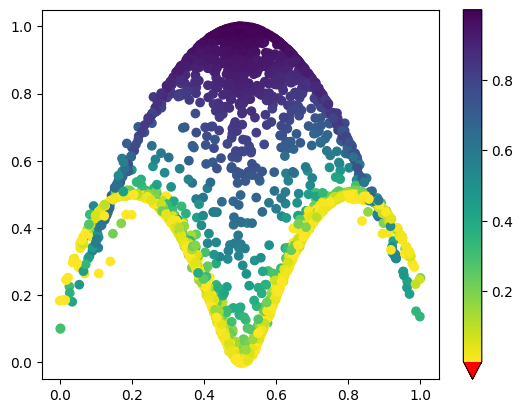

In [87]:
plot_scatter(plt.axes(), wref_states, s_wref.data['Entropy'], s_wref.data['LogNeg'])

<Axes: >

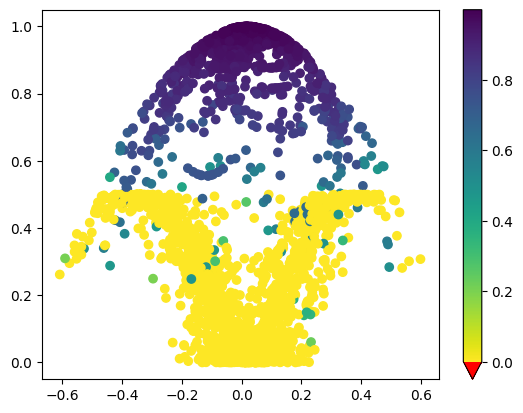

In [639]:
plot_scatter(plt.axes(), pca.fit_transform(conv_arr(s_nref.data['State'])), s_nref.data['Entropy'], s_nref.data['LogNeg'])

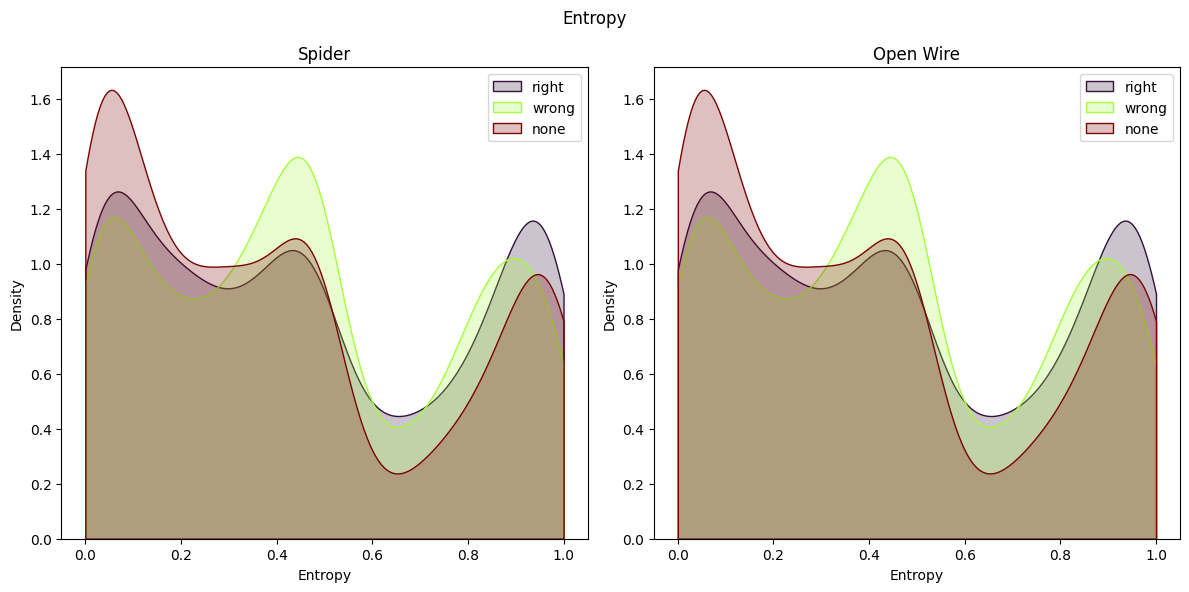

In [547]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(1,2,1)
plot_dist(ax, [s_rref.data['Entropy'], s_wref.data['Entropy'], s_nref.data['Entropy']], ['right', 'wrong', 'none'], "Spider")

ax = fig.add_subplot(1,2,2)
plot_dist(ax, [ow_rref.data['Entropy'], ow_wref.data['Entropy'], ow_nref.data['Entropy']], ['right', 'wrong', 'none'], "Open Wire")

fig.suptitle("Entropy")
fig.tight_layout()
#fig.savefig("figures/new_figs/cnxt")
#fig.supxlabel("CbD Measure")
#fig.supylabel("Contextual Fraction")

In [544]:
def get_ref_type(df1, df2, ref_type='right'):
    subj_arr = ['heart', 'sailors', 'students', 'knife', 'storm', 'bee', 'birds', 'police', 'people', 'sniper']
    #obj_arr = ['blood', 'boats', 'books', 'fence', 'flight', 'flower', 'seeds', 'criminals', 'government', 'terrorist']
    
    subj, obj = [], []
    i = j = 0
    while i < len(df1):
        if df1.iloc[i]['Sentence'].split('.')[0] == df2.iloc[j]['sentence1']:
            ref = df2.iloc[j]['referent']
            if ref_type != 'right':
                ref = df2.iloc[j]['wrong_referent']
            if ref in subj_arr:
                subj.append(i)
            else:
                obj.append(i)
            i += 1
            j += 1
        else:
            j += 1 
    return subj, obj

In [545]:
def get_encs(df):
    encs = []
    for i, row in df.iterrows():
        state = abs(row['State'])
        enc = 0
        for j in range(4):
            enc += round(state[j],3) * (10**(j*3))
        encs.append(enc)
    return normalise(encs)

In [205]:
spearmanr(a['CF'], a['CbD'])

SignificanceResult(statistic=0.12412263212500321, pvalue=5.945133145752443e-12)

In [420]:
def get_sim(df_arr):
    common_sentences = [[] for _ in df_arr]
    min_i = 0
    for i in range(len(df_arr)):
        if len(df_arr[i]) < len(df_arr[min_i]):
            min_i = i
    min_df = df_arr.pop(min_i)
    for i, row in min_df.iterrows():
        res_arr = []
        for df in df_arr:
            res = df.loc[df['Sentence'] == row['Sentence']]
            if len(res) == 0:
                break
            res_arr.append(res.index[0])
        if len(res_arr) == len(df_arr):
            res_arr.insert(min_i, i)
            for j in range(len(res_arr)):
                common_sentences[j].append(res_arr[j])
    df_arr.insert(min_i, min_df)
    return [df.iloc[ints] for df, ints in zip(df_arr, common_sentences)]

In [519]:
list(s_rref.data['Sentence'][s_rref.data['Entropy'] < 0.05])

['The sniper took aim the ruthless terrorist. He was a barbaric bomb maker.',
 'The police chased the criminals for hours. They were notorious and dangerous.',
 'The storm devastated the commercial flight. It was putting lives in peril.',
 'The chirpy birds foraged for the seeds. They were seeking new experiences.',
 'The clever bee crawled on the flower. It was producing honey.',
 'The active bee hovered above the flowering flower. It was an untouched paradise.',
 'The birds feasted on the crisp seeds. They were savory.',
 'The powerful knife sliced through the parking fence separating the yards. It was a transparent and thin.',
 'The turbulent storm prevented the flight. It was flying to Hawaii.',
 'The impulsive sailors jumped from the boats. They were tipping over.',
 'The sailors jumped off the boats. They were avoiding capsizing.',
 'The brave bee stopped at the abundant flower. It was searching for pollen.',
 'The birds flitted to the slow seeds. They were flying to new destinat